In [13]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats
import pywt
import os


In [15]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.manifold import SpectralEmbedding
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d
# %matplotlib widget

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

## Load data

In [16]:
figs_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_3\supp\suppl_7')

In [17]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')
tensor =fl.load(master_path/ 'tensors' /'tensor_ipsi_contra_pos.h5')
features = pd.read_csv(master_path/ 'features_bouts_new.csv')
df_features = pd.read_csv(master_path /'heatmap_features.csv')

tail = tensor[:, 0]
fin_1 = tensor[:,1]
fin_2 = tensor[:,2]

fin_all = np.concatenate((fin_1 ,fin_2),axis=-1)

In [18]:
df_features.columns

Index(['ipsi_n_oscillation', 'contra_n_oscillation', 'ipsi_frequency',
       'contra_frequency', 'ipsi_max_amplitude', 'contra_max_amplitude',
       'ipsi_fin_duration', 'contra_fin_duration', 'ipsi_amp_diff_peaks',
       'contra_amp_diff_peaks', 'ipsi_amp_1', 'contra_amp_1', 'ipsi_amp_2',
       'contra_amp_2', 'ipsi_t_diff_peak_1', 'contra_t_diff_peak_1',
       'ipsi_t_diff_peak_2', 'contra_t_diff_peak_2',
       'ispi_contra_correlation'],
      dtype='object')

In [19]:
results_path = master_path / 'Embeddings'

In [20]:
matrix_fins_cov = fl.load(results_path/ 'matrix_fins_cov.h5')
X_transformed = fl.load(results_path/ 'fin_cov_embeddings.h5')

In [21]:
clusters_ = features.cluster.values
clusters = features.cluster.values
clusters.shape

(11063,)

## Compute

In [22]:
# fin space cov
X = np.abs(matrix_fins_cov)
X[np.diag_indices_from(X)] = 0

NX_transformed = X_transformed
NX_transformed[:,0] = NormalizeData(X_transformed[:,0])
NX_transformed[:,1] = NormalizeData(X_transformed[:,1])
NX_transformed[:,2] = NormalizeData(X_transformed[:,2])


### Correlate with features

In [23]:
corr_feat_grad = np.zeros((X_transformed.shape[1],df_features.values.shape[1]))

for i in range(df_features.values.shape[1]):
    a0=np.ma.masked_invalid(X_transformed[:,0])
    a1=np.ma.masked_invalid(X_transformed[:,1])
    a2=np.ma.masked_invalid(X_transformed[:,2])

    b=np.ma.masked_invalid(df_features.values[:,i])
    msk0 = (~a0.mask & ~b.mask)
    msk1 = (~a1.mask & ~b.mask)
    msk2 = (~a2.mask & ~b.mask)
    corr_feat_grad[0,i] = np.ma.corrcoef(a0[msk0],b[msk0])[0,1]
    corr_feat_grad[1,i] = np.ma.corrcoef(a1[msk1],b[msk1])[0,1]
    corr_feat_grad[2,i] = np.ma.corrcoef(a2[msk2],b[msk2])[0,1]



### Features on manifold

In [24]:
feat = np.array(df_features.columns)[0]
feat

'ipsi_n_oscillation'

In [25]:
alph=0.75
dot_size=1
cm = 1/2.54  # centimeters in inches
f_size = 16
dpi=600

ipsi_n_oscillation
contra_n_oscillation
ipsi_frequency
contra_frequency
ipsi_max_amplitude
contra_max_amplitude
ipsi_fin_duration
contra_fin_duration
ipsi_amp_diff_peaks
contra_amp_diff_peaks
ipsi_amp_1
contra_amp_1
ipsi_amp_2
contra_amp_2
ipsi_t_diff_peak_1
contra_t_diff_peak_1
ipsi_t_diff_peak_2
contra_t_diff_peak_2
ispi_contra_correlation


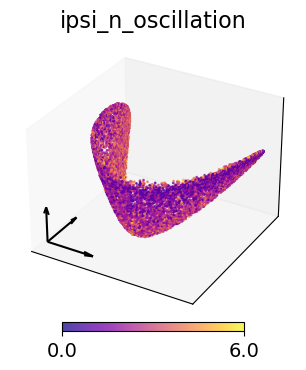

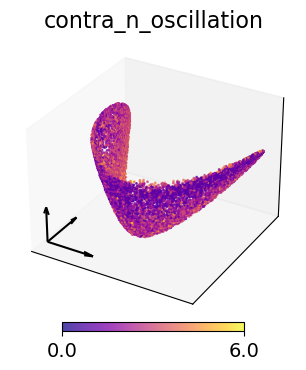

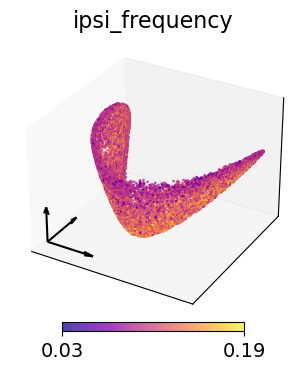

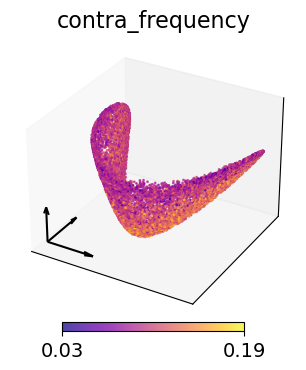

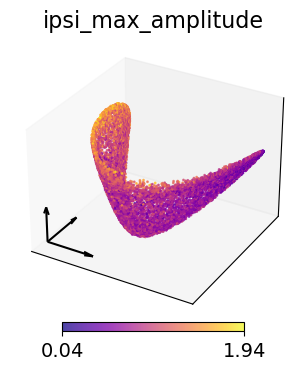

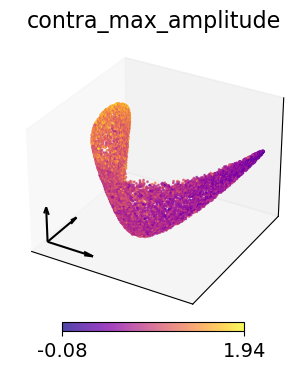

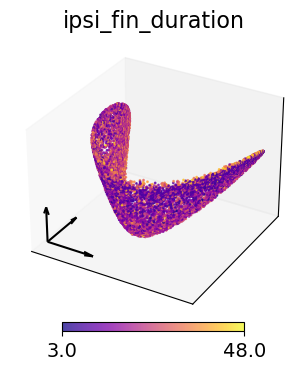

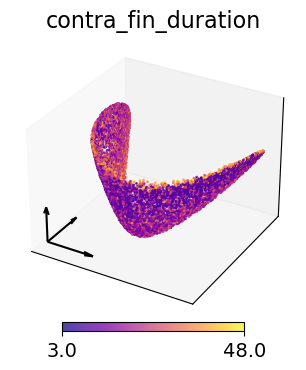

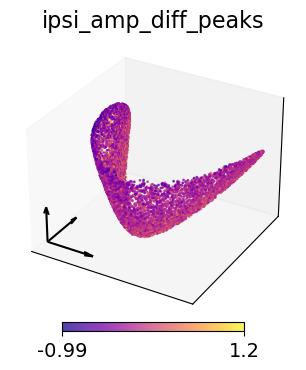

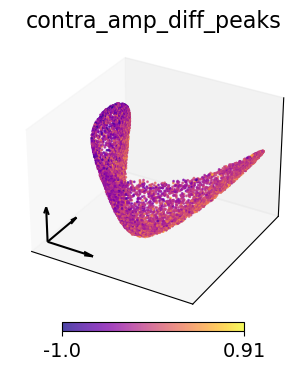

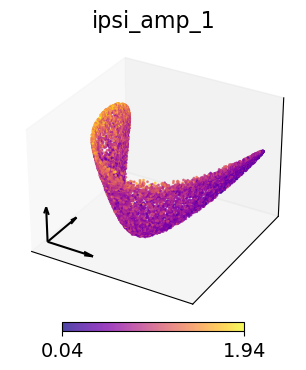

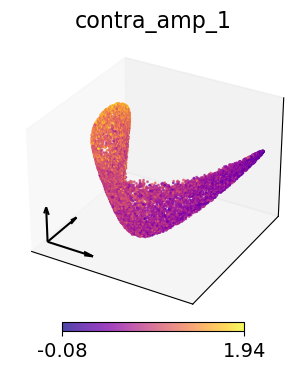

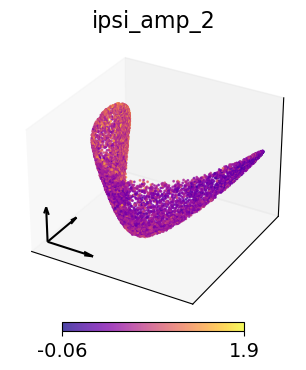

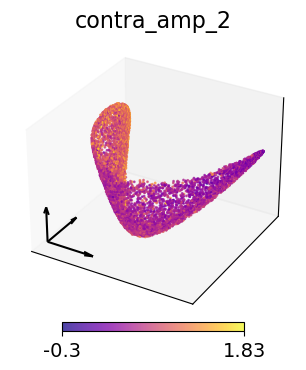

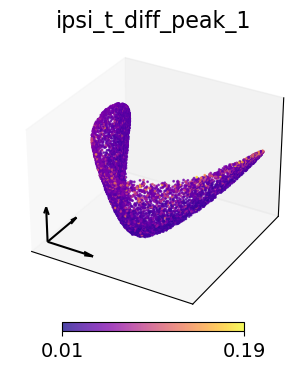

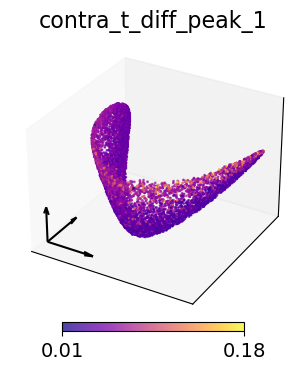

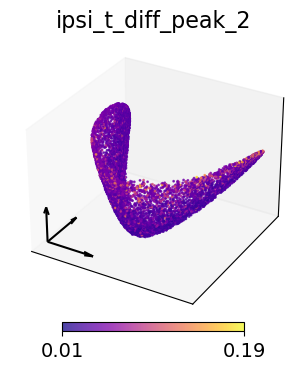

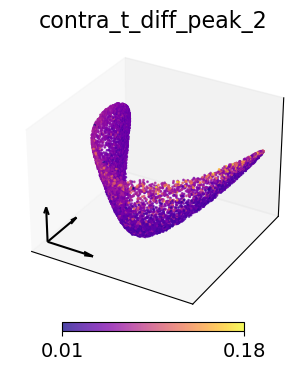

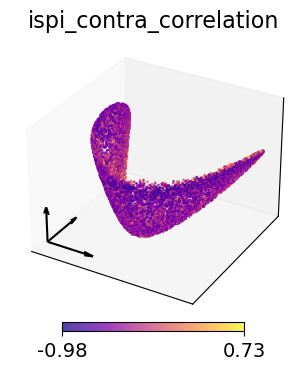

In [26]:
for i in range(len(df_features.columns)):
    feat = np.array(df_features.columns)[i]
    print (feat)
    fig = plt.figure(figsize=(10*cm, 10*cm))
    ax = fig.add_subplot(projection='3d')
    fig.patch.set_facecolor('none')
    sc = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2], alpha=alph, s=dot_size,c=df_features[feat], cmap='plasma')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.title(feat, fontsize=f_size)
    cbar= plt.colorbar(sc, shrink=0.5, orientation='horizontal',pad=0)
    # cbar.set_label(feat, size=f_size-2)
    cbar.ax.tick_params(labelsize=f_size)
    cbar.set_ticks([np.min(df_features[feat]),np.max(df_features[feat])])
    cbar.set_ticklabels([np.round(np.min(df_features[feat]),2),np.round(np.max(df_features[feat]),2)], fontsize=f_size-2)
    
    origin = np.array([0, 0, 0])
    u = np.array([1, 0, 0])  # x-axis unit vector
    v = np.array([0, 1, 0])  # y-axis unit vector
    w = np.array([0, 0, 1])  # z-axis unit vector
    
    # Plot the vectors using quiver
    ax.quiver(*origin, *u/3, color='k', label='x-axis (i)', arrow_length_ratio=0.2)
    ax.quiver(*origin, *v/3, color='k', label='y-axis (j)', arrow_length_ratio=0.2)
    ax.quiver(*origin, *w/3, color='k', label='z-axis (k)', arrow_length_ratio=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    plt.tight_layout()
    fig.savefig('{}/3DEMB_{}.png'.format(figs_path, feat), format='png', dpi=dpi)